In [2]:
import numpy as np
from scipy.fftpack import fft, fftshift

from IPython.display import display_html
display_html("""
<div style="text-align:center; margin: 20px 0;">
<p style="color:#FA5882;text-align:center; margin: 10px 0 20px 0;">
</p>
<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Folding code</button>
<hr/>
</div>
""", raw=True)

E1, E2, w, sigma, nc = 0.08, 0.046, 0.057, 30*41.34, 15
tl, tr = -3000, 3000
t = np.linspace(tl, tr, 10001)
nt = len(t)
dt = t[1] - t[0]

def E_FW_S(theta,t):           
    return E1*cos(theta)*exp(-2*log(2)*(t/sigma)**2)*cos(w*t)
def E_FW_P(theta,t):         
    return E1*sin(theta)*exp(-2*log(2)*(t/sigma)**2)*cos(w*t)
def E_DF_S(t,tau):                   
    return E2*exp(-2*log(2)*((t-tau)/sigma)**2)*cos(2*w*(t-tau))

Ei, Eh = 15.576/27.2116, 0.5  #Eh ⁢and ⁢𝐸i ⁢are⁢ the⁢ ionization⁢ potentials⁢ of⁢ hydrogen⁢ and⁢ the⁢ atom⁢ in⁢ question.
# Ei, Eh = 0.5, 0.5 
r = Ei/Eh
Ng = 2.4 * 10 ** 19 * (0.5292 * 10 ** (-8)) ** 3 
def W(E):    #定义电离率
    E = 0.0000001 + abs(E)
    return (4.0/E)*r**(5/2)*exp((-2/(3*E))*(r**(3/2)))

Folding code

In [3]:
figure(figsize=(11,6))
plot(t, E_FW_S(0,t))
plot(t, E_DF_S(t,0))
axvline(x=0, color = 'black', linestyle = '-.', linewidth=1)
#xlim(-1100,1100)

NameError: name 'figure' is not defined

In [8]:
N = 40
pp_tds_S, pp_tds_P = zeros((N,N)), zeros((N,N))
TDS_sum = zeros(((N,N)), dtype=complex)
pp_TDS_sum, angle_max_TDS_sum = zeros((N,N)), zeros((N,N))
THG_S, THG_P = [[] for i in range(N)], [[] for i in range(N)]

theta0 = np.linspace(0, 0.5*np.pi, N)
tau0 = np.linspace(0, 1.333*41.34, N)

for i in range(N):
    for j in range(N):
        ES = E_DF_S(t,tau0[i])+E_FW_S(theta0[j],t)  
        EP = E_FW_P(theta0[j],t)
        
        E, Ne = zeros(nt, dtype = complex), zeros(nt)
        E.real, E.imag = ES, EP
        
        Ne[0] = Ng*W(abs(E[0]))
        Ne[1] = Ne[0] + (Ng-Ne[0])*W(abs(E[1]))
        for k in range(nt-2):
            Ne[k+2] = Ne[k] + 2*(Ng - Ne[k+1]) * W(abs(E[k+1])) * dt
#         for k in range(nt-1):
#             Ne[k+1] = Ne[k] + (Ng-Ne[k])*W(E[k+1])*dt
        
        dJ_dt_S = Ne*ES
        dJ_dt_P = Ne*EP
        
        mul = 10*t.size
        D_S_ext = np.pad(dJ_dt_S, (mul, mul),'constant')
        D_P_ext = np.pad(dJ_dt_P, (mul, mul),'constant')    #补零    
        
        fre_S, fre_P = fft(D_S_ext), fft(D_P_ext)
        THG_S[i].append(sum(abs(fre_S[3427])**2))
        THG_P[i].append(sum(abs(fre_P[3427])**2))        #傅里叶变化到频域
        fre_S_thz = zeros(D_S_ext.size, complex)
        fre_P_thz = zeros(D_P_ext.size, complex)   
#         con_2 = int((0.0177)/(2*pi*(1/(len(D_S_ext)*dt)))/2)   #0.0106394 对应70THz
        con_2 = int((0.0106394)/(2*pi*(1/(len(D_S_ext)*dt)))/2)   #0.0106394 对应70THz
        con_1 = con_2  
        fre_S_thz[0:con_1], fre_P_thz[0:con_1] = fre_S[0:con_1], fre_P[0:con_1]
        fre_S_thz[(D_S_ext.size-con_2):D_S_ext.size]=fre_S[(D_S_ext.size-con_2):D_S_ext.size]
        fre_P_thz[(D_P_ext.size-con_2):D_P_ext.size]=fre_P[(D_P_ext.size-con_2):D_P_ext.size]     #取其THz低频部分
        tds_S, tds_P = ifft(fre_S_thz).real, ifft(fre_P_thz).real                                 #逆傅里叶变换到时域，得到TDS
            
        pp_tds_S[j,i], pp_tds_P[j,i] = real(fre_S[0]), real(fre_P[0])
        TDS_sum[j,i] = pp_tds_S[j,i] + pp_tds_P[j,i]*1j
       
        if (angle(TDS_sum[j,i]) < 0 or angle(TDS_sum[j,i]) == (1*pi)):
            pp_TDS_sum[j,i] = -abs(TDS_sum[j,i])
        else:
            pp_TDS_sum[j,i] = abs(TDS_sum[j,i])  
        
        angle_max_TDS_sum[j,i] = angle(TDS_sum[j,i])        
td = linspace(-(2*mul/t.size+1)*tl, (2*mul/t.size+1)*tr, D_S_ext.size)    

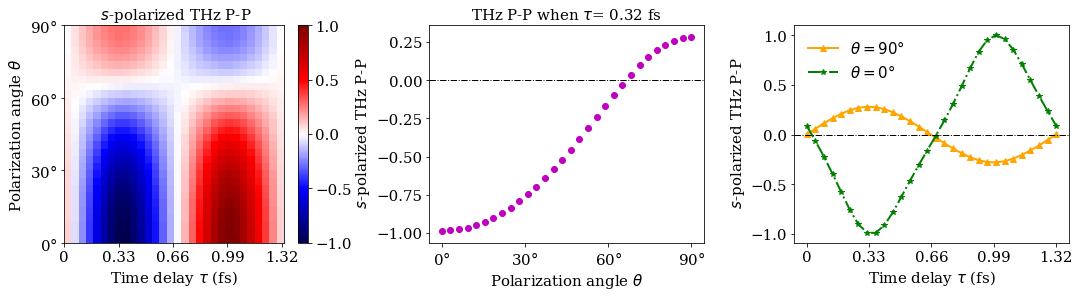

In [8]:
Size=15
nofont = {'fontname':'serif'}
chfont = {'fontname':'serif'}
figsize(18,4)
subplot(131)
extent=[0,1.333,0,90]
imshow(pp_tds_S/amax(abs(pp_tds_S)),extent=extent,cmap='seismic', aspect='auto',origin='lower')
title(' $s$-polarized THz P-P',size=Size,**chfont)
clim(-1,1)
cb=colorbar()
cb.set_ticks(linspace(-1,1,5))
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('serif')

matplotlib.rc('xtick',labelsize=Size)
matplotlib.rc('ytick',labelsize=Size)

ax=plt.gca()
Xscale=around(arange(0,1.333,0.33),decimals=2)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.33','0.66','0.99','1.32'),**nofont)
Yscale=linspace(0,90,4)
ax.set_yticks(Yscale)
ax.set_yticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
    
xlabel(r"Time delay $\tau $ (fs)",size=Size,**chfont)
ylabel(r'Polarization angle $\theta$',size=Size,**chfont)

subplot(132)
phase=7
Ang=linspace(0,90,N)
Phase=linspace(0,1.333,N)
scatter(Ang,pp_tds_S[:,phase]/amax(abs(pp_tds_S)),color='m')
axhline(y=0,color='black',linestyle='-.',linewidth=1)
ax=plt.gca()
Xscale=linspace(0,90,4)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
for label in (ax.get_yticklabels()):
    label.set_fontname('serif')
xlabel(r'Polarization angle $\theta$',size=Size,**nofont)
ylabel(r' $s$-polarized THz P-P',size=Size,**nofont)
title(r'THz P-P when $\tau$= %0.2f fs' %(Phase[1]*phase),size=Size,**nofont)

subplot(133)
angle=29
plot(Phase,pp_tds_S[angle,:]/amax(pp_tds_S),color="orange",linewidth=2,linestyle='-',marker='^',label=r'$\theta=%d \degree$' %(Ang[1]*angle))
plot(Phase,pp_tds_S[0,:]/amax(pp_tds_S),color="green",linewidth=2,linestyle='-.',marker='*',label=r'$\theta=%d \degree$' %(0))
legend(loc=2, prop={'size': 15},frameon=False)
axhline(y=0,color='black',linestyle='-.',linewidth=1)
ax=plt.gca()
Xscale=linspace(0,1.333,5)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.33','0.66','0.99','1.32'),**nofont) 
for label in (ax.get_yticklabels()):
    label.set_fontname('serif')
ax.yaxis.get_major_formatter().set_powerlimits((0,2))
xlabel(r'Time delay $\tau$ (fs)',size=Size,**nofont)
ylabel(r' $s$-polarized THz P-P',size=Size,**nofont)
#title(r'THz P-P when $\theta$=%d$\degree$' %(Ang[1]*angle),size=Size,**nofont)
subplots_adjust(wspace=0.33)
#savefig('analysis/S_THz_PP.png',dpi=512, bbox_inches='tight')

$这里是以氮气分子为研究对象,并对其进行类氢化处理,第一电离能为0.5724\ a.u.$

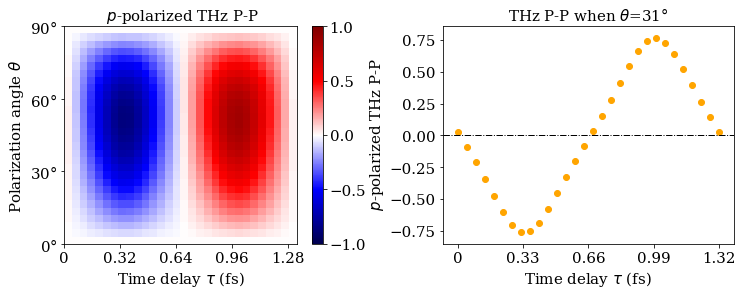

In [10]:
figsize(12,4)
subplot(121)
extent=[0,1.334,0,90]
imshow(pp_tds_P/amax(abs(pp_tds_S)),extent=extent,cmap="seismic", aspect='auto',origin='lower')

title(' $p$-polarized THz P-P',size=Size,**chfont)
clim(-1,1)
cb=colorbar()
cb.set_ticks(linspace(-1,1,5))
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('serif')

matplotlib.rc('xtick',labelsize=Size)
matplotlib.rc('ytick',labelsize=Size)

ax=plt.gca()
Xscale=around(arange(0,1.334,0.32),decimals=2)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.32','0.64','0.96','1.28'),**nofont)
Yscale=linspace(0,90,4)
ax.set_yticks(Yscale)
ax.set_yticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
    
xlabel(r"Time delay $\tau $ (fs)",size=Size,**chfont)
ylabel(r'Polarization angle $\theta$',size=Size,**chfont)
subplot(122)
angle=10
scatter(Phase,pp_tds_P[angle, :]/amax(pp_tds_P),color="orange")
axhline(y=0,color='black',linestyle='-.',linewidth=1)
ax=plt.gca()
Xscale=linspace(0,1.333,5)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.33','0.66','0.99','1.32'),**nofont) 
for label in (ax.get_yticklabels()):
    label.set_fontname('serif')
ax.yaxis.get_major_formatter().set_powerlimits((0,2))
xlabel(r'Time delay $\tau$ (fs)',size=Size,**nofont)
ylabel(r' $p$-polarized THz P-P',size=Size,**nofont)
title(r'THz P-P when $\theta$=%d$\degree$' %(Ang[1]*angle),size=Size,**nofont)
subplots_adjust(wspace=0.3)
#savefig('analysis/THz_PP.png',dpi=512, bbox_inches='tight')

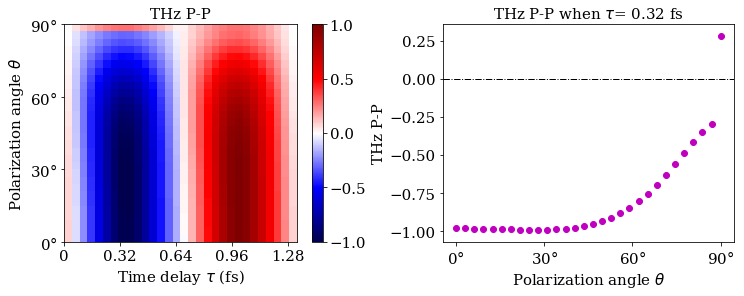

In [6]:
figsize(12,4)
subplot(121)
extent=[0,1.334,0,90]
imshow(pp_TDS_sum/amax(abs(pp_TDS_sum)),extent=extent,cmap="seismic", aspect='auto',origin='lower')

title('THz P-P',size=Size,**chfont)
clim(-1,1)
cb=colorbar()
cb.set_ticks(linspace(-1,1,5))
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family('serif')

matplotlib.rc('xtick',labelsize=Size)
matplotlib.rc('ytick',labelsize=Size)

ax=plt.gca()
Xscale=around(arange(0,1.334,0.32),decimals=2)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.32','0.64','0.96','1.28'),**nofont)
Yscale=linspace(0,90,4)
ax.set_yticks(Yscale)
ax.set_yticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
    
xlabel(r"Time delay $\tau $ (fs)",size=Size,**chfont)
ylabel(r'Polarization angle $\theta$',size=Size,**chfont)

subplot(122)
phase=7
Ang=linspace(0,90,N)
Phase=linspace(0,1.333,N)
scatter(Ang,pp_TDS_sum[:,phase]/amax(abs(pp_TDS_sum)),color='m')
axhline(y=0,color='black',linestyle='-.',linewidth=1)
ax=plt.gca()
Xscale=linspace(0,90,4)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
for label in (ax.get_yticklabels()):
    label.set_fontname('serif')
xlabel(r'Polarization angle $\theta$',size=Size,**nofont)
ylabel(r'THz P-P',size=Size,**nofont)
title(r'THz P-P when $\tau$= %0.2f fs' %(Phase[1]*phase),size=Size,**nofont)
subplots_adjust(wspace=0.3)

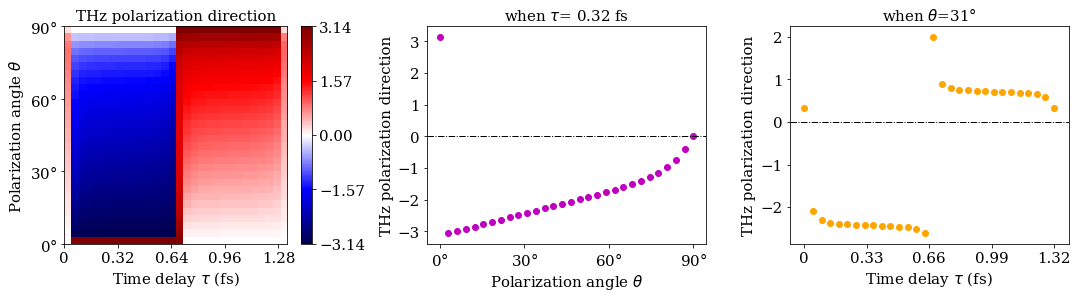

In [7]:
figsize(18,4)
subplot(131)
extent=[0,1.334,0,90]
imshow(angle_max_TDS_sum,extent=extent,cmap="seismic", aspect='auto',origin='lower')
title('THz polarization direction',size=Size,**chfont)
cb=colorbar()
clim(-3.14,3.14)
cb.set_ticks(linspace(-3.14,3.14,5))
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("serif")

matplotlib.rc('xtick',labelsize=Size)
matplotlib.rc('ytick',labelsize=Size)

ax=plt.gca()
Xscale=around(arange(0,1.334,0.32),decimals=2)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.32','0.64','0.96','1.28'),**nofont)
Yscale=linspace(0,90,4)
ax.set_yticks(Yscale)
ax.set_yticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
    
xlabel(r"Time delay $\tau $ (fs)",size=Size,**chfont)
ylabel(r'Polarization angle $\theta$',size=Size,**chfont)
subplot(132)
phase=7
Ang=linspace(0,90,N)
Phase=linspace(0,1.333,N)
scatter(Ang,angle_max_TDS_sum[:,phase],color='m')
axhline(y=0,color='black',linestyle='-.',linewidth=1)
ax=plt.gca()
Xscale=linspace(0,90,4)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)
for label in (ax.get_yticklabels()):
    label.set_fontname('serif')
xlabel(r'Polarization angle $\theta$',size=Size,**nofont)
ylabel(r'THz polarization direction',size=Size,**nofont)
title(r'when $\tau$= %0.2f fs' %(Phase[1]*phase),size=Size,**nofont)
subplot(133)
angle=10
scatter(Phase,angle_max_TDS_sum[angle,:],color="orange")
axhline(y=0,color='black',linestyle='-.',linewidth=1)
ax=plt.gca()
Xscale=linspace(0,1.333,5)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.33','0.66','0.99','1.32'),**nofont) 
for label in (ax.get_yticklabels()):
    label.set_fontname('serif')
ax.yaxis.get_major_formatter().set_powerlimits((0,2))
xlabel(r'Time delay $\tau$ (fs)',size=Size,**nofont)
ylabel(r'THz polarization direction',size=Size,**nofont)
title(r'when $\theta$=%d$\degree$' %(Ang[1]*angle),size=Size,**nofont)
subplots_adjust(wspace=0.3)

Text(0,0.5,'Polarization angle $\\theta$')

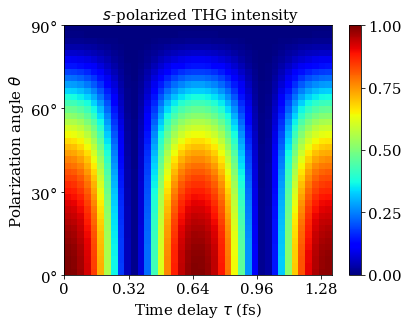

In [9]:
Size = 15
figsize(6,4.59)
extent=[0,1.334,0,90]
imshow(transpose(THG_S)/amax(THG_S),extent=extent,cmap="jet", aspect='auto',origin='lower')
nofont = {'fontname':'serif'}

title(' $s$-polarized THG intensity',size=Size,**nofont)
clim(0,1)
cb=colorbar()
cb.set_ticks(around(linspace(0,amax(THG_S)/amax(THG_S),5),decimals=3))
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("serif")


matplotlib.rc('xtick',labelsize=Size)
matplotlib.rc('ytick',labelsize=Size)

ax=plt.gca()
Xscale=around(arange(0,1.334,0.32),decimals=2)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.32','0.64','0.96','1.28'),**nofont)
Yscale=linspace(0,90,4)
ax.set_yticks(Yscale)
ax.set_yticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)

xlabel(r"Time delay $\tau $ (fs)",size=Size,**nofont)
ylabel(r'Polarization angle $\theta$',size=Size,**nofont)

Text(0,0.5,'Polarization angle $\\theta$')

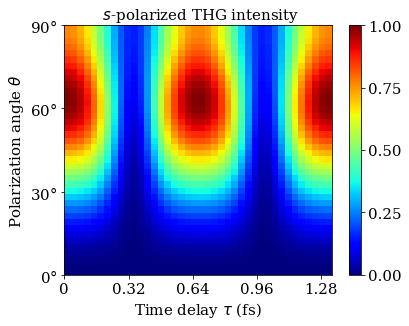

In [10]:
Size = 15
figsize(6,4.59)
extent=[0,1.334,0,90]
imshow(transpose(THG_P)/amax(THG_P),extent=extent,cmap="jet", aspect='auto',origin='lower')
nofont = {'fontname':'serif'}

title(' $s$-polarized THG intensity',size=Size,**nofont)
#clim(0,1)
cb=colorbar()
cb.set_ticks(around(linspace(0,amax(THG_P)/amax(THG_P),5),decimals=3))
for l in cb.ax.yaxis.get_ticklabels():
    l.set_family("serif")


matplotlib.rc('xtick',labelsize=Size)
matplotlib.rc('ytick',labelsize=Size)

ax=plt.gca()
Xscale=around(arange(0,1.334,0.32),decimals=2)
ax.set_xticks(Xscale)
ax.set_xticklabels(('0','0.32','0.64','0.96','1.28'),**nofont)
Yscale=linspace(0,90,4)
ax.set_yticks(Yscale)
ax.set_yticklabels(('0$\degree$','30$\degree$','60$\degree$','90$\degree$'),**nofont)

xlabel(r"Time delay $\tau $ (fs)",size=Size,**nofont)
ylabel(r'Polarization angle $\theta$',size=Size,**nofont)